In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud
from konlpy.tag import Twitter
from collections import Counter
from nltk.probability import FreqDist
from sklearn.preprocessing import QuantileTransformer

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 14

# Kakao Arena에서 제공하는 train, genre, meta 데이터 불러오기

In [2]:
# 데이터 확인하기

In [3]:
# train
# playlist data
train = pd.read_json('data/train.json') 

#genre
genre_gn_all = pd.read_json('data/genre_gn_all.json', typ='series')  
genre_gn_all = pd.DataFrame(genre_gn_all, columns = ['gnr_name']).reset_index().rename(columns = {'index' : 'gnr_code'}) 

# meta
meta = pd.read_json('data/song_meta.json')

## train data 컬럼의 의미     
- tags : 플레이리스트에 달려있는 태그 목록     
- id : 플레이리스트 아이디    
- plylst_title : 플레이리스 제목     
- songs : 플레이리스트에 수록된 곡      
- like_cnt : 플레이리스트 좋아요 수     
- updt_date : 플레이리스트가 최종 수정된 시각     
---


### Playlist
- 총 플레이리스트의 개수는 115071개     
- id가 연속적인 숫자가 아님. 
    인덱스로 새로운 아이디를 만들어 연속적인 지표가 되도록 만듦.     
--

###  like_cnt(좋아요 수)     
- `중간값` : 약 7 개, `평균값` : 약 95개, `max값` : 53211 개    
    중간값에 비해 평균값이 너무 높게 나옴. `좋아요`의 편중 정도가 심한 것을 확인.    

In [4]:
display(train.describe())
display(train.info())

,id,like_cnt
count,115071.000000,115071.000000
mean,76728.259501,95.197687
std,44313.134619,560.653757
min,1.000000,0.000000
25%,38277.500000,2.000000
50%,76732.000000,7.000000
75%,115061.500000,24.000000
max,153428.000000,53211.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115071 entries, 0 to 115070
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          115071 non-null  object
 1   id            115071 non-null  int64 
 2   plylst_title  115071 non-null  object
 3   songs         115071 non-null  object
 4   like_cnt      115071 non-null  int64 
 5   updt_date     115071 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


None

## 장르    
- 254개의 장르가 있음.    
- 90개의 겹치는 장르가 있음. 30개의 세부장르 전체를 제외하고도 60개의 겹치는 장르가 있음.    

In [5]:
display(genre_gn_all.describe())
display(genre_gn_all.info())

,gnr_code,gnr_name
count,254,254
unique,254,164
top,GN0100,세부장르전체
freq,1,27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gnr_code  254 non-null    object
 1   gnr_name  254 non-null    object
dtypes: object(2)
memory usage: 4.1+ KB


None

---
## 곡 정보
- 707989개의 수록곡이 있음        
- album_name null값 4개가 있음       


In [6]:
display(meta.describe())
display(meta.info())

,issue_date,album_id,id
count,7.079890e+05,7.079890e+05,707989.000000
mean,2.003394e+07,3.869081e+06,353994.000000
std,1.263819e+06,3.966919e+06,204378.964203
min,0.000000e+00,1.600000e+01,0.000000
25%,2.008063e+07,4.113540e+05,176997.000000
50%,2.014032e+07,2.276384e+06,353994.000000
75%,2.017023e+07,1.002271e+07,530991.000000
max,2.022011e+07,1.042206e+07,707988.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


None

---

# 데이터프레임 확인

In [7]:
#song 데이터 확인
meta.head()

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4


---
태그와 수록곡이 리스트형태로 저장되어있는 것을 확인

In [8]:
#train 데이터 확인
train.head()

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000


---
대장르 30개와 세부장르 224개로 나뉘어져 있는 것을 확인.

In [9]:
# 장르 확인
genre_gn_all.head()

,gnr_code,gnr_name
0,GN0100,발라드
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00


In [10]:
train_df = train[['tags','plylst_title']]
train_df_tags = train_df['tags'].tolist()
train_df_tags = np.concatenate( train_df['tags'].values )
train_df_tags

array(['락', '추억', '회상', ..., '팝송추천', '팝송', '팝송모음'], dtype='<U18')

---
# 1. genre_gn_all.json (장르 정보)

## 1.1 장르 대분류

In [11]:
# 장르코드 뒷자리 두 자리가 00인 코드를 필터링
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']
gnr_code

,gnr_code,gnr_name
0,GN0100,발라드
6,GN0200,댄스
12,GN0300,랩/힙합
18,GN0400,R&B/Soul
22,GN0500,인디음악
32,GN0600,록/메탈
39,GN0700,성인가요
50,GN0800,포크/블루스
56,GN0900,POP
65,GN1000,록/메탈


- 대분류 장르는 총 30개

- **장르 이름(unique) 5개 중복**   

> 12	GN0300	랩/힙합, 90	GN1200	랩/힙합      
18	GN0400	R&B/Soul, 100	GN1300	R&B/Soul    
32	GN0600	록/메탈, 65	GN1000	록/메탈    
50	GN0800	포크/블루스, 109	GN1400	포크/블루스/컨트리 => 얘만 3개야       
80	GN1100	일렉트로니카, 232	GN2600	일렉트로니카  

중복되는 장르 이름 중 뒷 번호의 장르가 외국곡임을 확인할 수 있었다. 

## 1.2 장르 소분류

In [12]:
# 장르코드 뒷자리 두 자리가 00이 아닌 코드를 필터링
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

In [13]:
dtl_gnr_code.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 1 to 252
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dtl_gnr_code  224 non-null    object
 1   dtl_gnr_name  224 non-null    object
dtypes: object(2)
memory usage: 5.2+ KB


In [14]:
dtl_gnr_code.describe()

,dtl_gnr_code,dtl_gnr_name
count,224,224
unique,224,146
top,GN0101,세부장르전체
freq,1,27


- 세부 장르는 총 224개

## 1.3 장르 코드 트리(Tree)

In [15]:
# 앞자리 네 자리 공통코드 추출
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

# Merge
gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code')

gnr_code_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']]

,gnr_code,gnr_name,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN0101,세부장르전체
1,GN0100,발라드,GN0102,'80
2,GN0100,발라드,GN0103,'90
3,GN0100,발라드,GN0104,'00
4,GN0100,발라드,GN0105,'10-
...,...,...,...,...
220,GN2800,뮤직테라피,GN2806,반려동물
221,GN2900,뮤지컬,GN2901,세부장르전체
222,GN2900,뮤지컬,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN2903,국외뮤지컬


In [16]:
#크리스마스 null값 존재. 채워야함
gnr_code_tree.isna().sum()

gnr_code        0
gnr_name        0
join_code       0
dtl_gnr_code    1
dtl_gnr_name    1
dtype: int64

 - **크리스마스 장르(GN3000)의 세부장르 NaN값**

In [17]:
# 크리스마스 장르(GN3000)의 세부장르 NaN값
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN3000']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
224,GN3000,크리스마스,GN30,NaN,NaN


- **어린이/테교 장르(GN2200)에 상세장르인 영어동요 중복됨**

In [18]:
# 어린이/테교 장르(GN2200)에 상세장르인 영어동요 중복 
gnr_code_tree[gnr_code_tree['gnr_code'] == 'GN0200']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
5,GN0200,댄스,GN02,GN0201,세부장르전체
6,GN0200,댄스,GN02,GN0202,'80
7,GN0200,댄스,GN02,GN0203,'90
8,GN0200,댄스,GN02,GN0204,'00
9,GN0200,댄스,GN02,GN0205,'10-


> **같은 대분류 속 상세분류(dtl_gnr_name)가 중복되기도 함.   
GN2200	어린이/태교	GN2203	영어동요   
GN2200	어린이/태교	GN2204	영어동요   
GN2200	어린이/태교	GN2205	영어동요**   

---

# 2. song_meta.json ( 곡 정보 )

## 2.1. 기본 정보

  - `song_gn_dtl_gnr_basket` : 상세 장르 코드
  - `issue_date` : 곡 발매 일자 (yyyymmdd)
  - `album_name` : 앨범 명
  - `album_id` : 앨범 아이디
  - `artist_id_basket` : 아티스트 아이디 (복수일 경우 띄어쓰기로 구분)
  - `song_name` : 곡 명
  - `song_gn_gnr_basket` : 대분류 장르코드
  - `artist_name_basket` : 아티스트 명 (복수일 경우 띄어쓰기로 구분)
  - `id` : 곡 아이디

In [19]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   song_gn_dtl_gnr_basket  707989 non-null  object
 1   issue_date              707989 non-null  int64 
 2   album_name              707985 non-null  object
 3   album_id                707989 non-null  int64 
 4   artist_id_basket        707989 non-null  object
 5   song_name               707989 non-null  object
 6   song_gn_gnr_basket      707989 non-null  object
 7   artist_name_basket      707989 non-null  object
 8   id                      707989 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


In [20]:
display(meta.head(2))

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1


## 2.2. 중복 노래 확인
- 제목과 가수가 일치하면 같은 노래로 판단

In [21]:
title_artist_df = meta[['song_name','artist_name_basket']]
# 가수 이름 리스트를 스트링으로 변환
title_artist_df['artist_name_basket'] = title_artist_df['artist_name_basket'].map(lambda x: " ".join(x))

In [22]:
title_artist_df['artist_name_basket']

0         Various Artists
1          Murray Perahia
2           Peter Gabriel
3                  Matoma
4                Jude Law
               ...       
707984          Fela Kuti
707985       Cyndi Lauper
707986                윤종신
707987       Nature Piano
707988                김경호
Name: artist_name_basket, Length: 707989, dtype: object

In [23]:
#중복된 노래 수
len(meta) - len(title_artist_df.drop_duplicates())

84277

In [24]:
#중복 노래 확인
meta['artist_names'] = title_artist_df['artist_name_basket']
meta[title_artist_df.duplicated(keep=False)].sort_values(by = ['song_name','artist_names'])\
[['issue_date','song_gn_gnr_basket','album_name','song_name','artist_name_basket']].head(50)

,issue_date,song_gn_gnr_basket,album_name,song_name,artist_name_basket
97218,20190809,[GN1200],!,!,[Trippie Redd]
384892,20190808,[GN1200],!,!,[Trippie Redd]
352018,20140128,[GN0200],졸업,! (느낌표),[오늘 (Today)]
631373,20131227,[GN0200],오늘,! (느낌표),[오늘 (Today)]
176984,20170921,"[GN0500, GN0800]",포크라노스 컴필레이션 Vol.1 `EMERGING`,#,[끝없는잔향속에서우리는]
228114,20170107,"[GN0500, GN0600]",우연의 연속에 의한 필연,#,[끝없는잔향속에서우리는]
551475,19950815,[GN1000],Garbage,#1 Crush,[Garbage]
697292,20070724,"[GN0900, GN1000]",Absolute Garbage,#1 Crush,[Garbage]
132654,20110829,"[GN0900, GN1000]",Night Shades (Deluxe),#1Nite (One Night),[Cobra Starship]
509191,20120613,[GN0900],#1Nite (One Night) (Album Ver.),#1Nite (One Night),[Cobra Starship]


서로 다른 앨범에 수록되며 중복이 발생하고 장르가 추가되는 경우도 있음.

## 2.3. 노래 장르

In [25]:
#곡 하나가 가지는 디테일 장르 수
meta[['song_gn_dtl_gnr_basket']].applymap(lambda x : len(x)).value_counts().sort_index()

song_gn_dtl_gnr_basket
0                           4037
1                         218835
2                         292539
3                         106497
4                          46259
5                          37238
6                           1207
7                            927
8                            210
9                             71
10                           148
11                            17
12                             4
dtype: int64

- 장르가 없는 노래가 있다.

In [26]:
# 장르 소분류가 없는 노래들
song_no_dtl_gnr = meta[meta['song_gn_dtl_gnr_basket'].map(lambda x : len(x) < 1)]
song_no_dtl_gnr.head(10)

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,artist_names
21,[],20200331,WHY,10410508,[417985],WHY,[],[4minute],21,4minute
262,[],20150318,노년의 건강을 지켜주는 음악 처방전 (부제 : 휴식 때 들으면 좋은 음악친구),2309524,[726909],Bio Sound `Breathing & Big Bell`,[GN9000],[차병원],262,차병원
399,[],20200106,뽀로로 겨울 동요,10372098,[1703695],초코 초코 핫초코,[],[아이코닉스 (ICONIX)],399,아이코닉스 (ICONIX)
454,[],20191108,MAGDALENE,10349014,[788767],thousand eyes,[GN1100],[FKA Twigs],454,FKA Twigs
803,[],20040901,Tropical Lullaby,153435,[848353],Kalua Lullaby,[],[The Moonlighters],803,The Moonlighters
916,[],20170825,크리스마스의 기적,10090652,[750416],Springtime In December,[GN9000],[Larry Warren],916,Larry Warren
1074,[],20131128,Open It Up,10008901,[1221466],Open It Up,[GN9000],[Tchengiz],1074,Tchengiz
1089,[],20190924,66,10331496,[2747498],How are you,[],[유노이아 (Eunoia)],1089,유노이아 (Eunoia)
2061,[],20200416,주의 집에 거하는 자,10417840,[2295323],주의 집에 거하는 자 (Blessed),[GN2100],[예람워십],2061,예람워십
2205,[],20161130,크리스마스 하프 감성 연주곡 베스트,10019367,[923656],고요한 밤 거룩한 밤 (Silent Night Holy Night) (크리스마스 하프),[GN9000],[크리스마스 캐롤송],2205,크리스마스 캐롤송


> **장르 대분류가 있는 곡들의 소분류를 각 분류의 01번으로 채울 수 있다.   

장르 소분류 대분류 모두 없는 곡

In [27]:
song_no_all_gnr = song_no_dtl_gnr[song_no_dtl_gnr['song_gn_gnr_basket'].map(lambda x : len(x) == 0)]
display(song_no_all_gnr.head())
print(song_no_all_gnr.shape)

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,artist_names
21,[],20200331,WHY,10410508,[417985],WHY,[],[4minute],21,4minute
399,[],20200106,뽀로로 겨울 동요,10372098,[1703695],초코 초코 핫초코,[],[아이코닉스 (ICONIX)],399,아이코닉스 (ICONIX)
803,[],20040901,Tropical Lullaby,153435,[848353],Kalua Lullaby,[],[The Moonlighters],803,The Moonlighters
1089,[],20190924,66,10331496,[2747498],How are you,[],[유노이아 (Eunoia)],1089,유노이아 (Eunoia)
2588,[],20080709,명상태교음악 `평온` Vol.4,392967,[2727],Dvorak : Humoresque No.7 Op.101,[],[Various Artists],2588,Various Artists


(1059, 10)


In [28]:
# 어떤 곡들인지 샘플 확인
song_no_all_gnr.sample(50)

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,artist_names
671710,[],19580000,Merry Christmas,305795,[28201],The First Noel,[],[Johnny Mathis],671710,Johnny Mathis
665854,[],20200406,I trust,10413088,[2137482],Oh my god (English Ver.),[],[(여자)아이들],665854,(여자)아이들
635763,[],20191028,RE_vive,10344546,[181694],미소를 띄우며 나를 보낸 그 모습처럼,[],[브라운아이드걸스],635763,브라운아이드걸스
217193,[],20091118,Christmas Pop,718984,[2727],Away In A Manner Ballad,[],[Various Artists],217193,Various Artists
175877,[],20191104,S.O.L,10347216,[913163],돌아보지마 (Follow Me & You),[],[이진혁],175877,이진혁
348320,[],20200331,WHY,10410508,[417985],WHY (Instrumental),[],[4minute],348320,4minute
224771,[],20200304,Upgrade Ⅳ,10398481,[236970],브레익 유어 페이스 (Feat. Owen),[],[스윙스],224771,스윙스
63019,[],20200130,행보 2019 윤종신,10381365,[437],이별손님,[],[윤종신],63019,윤종신
262258,[],20200225,낭만닥터 김사부 2 OST,10393897,"[27619, 726783]",Love and Hatred,[],"[전창엽, 마마고릴라]",262258,전창엽 마마고릴라
263586,[],20191112,곽철용,10350534,[2743464],곽철용,[],[Northfacegawd],263586,Northfacegawd


- 1059개의 곡은 장르 대분류 소분류 모두 누락됨
> **몇 개 멜론에서 검색해보니 실제 장르 분류는 되어있음  
> ost 경음악, 클래식, 동요 등 마이너한 곡들로 생각했으나 아이돌 가수등 메이저한 경우도 존재  

### 2.3.1 장르별 노래 집계

In [29]:
# 장르 맵핑을 위한 df 만들기
song_mm = meta.copy()
#장르가 여러개일 경우 가장 앞에있는 장르로 한다.
song_mm['song_gn_gnr_basket'] = song_mm['song_gn_gnr_basket'].apply(lambda x : "".join(x)[:6])
song_mm['artist_name_basket'] = song_mm['artist_name_basket'].apply(lambda x : "".join(x))
song_mm.rename(columns = {'song_gn_gnr_basket':'gnr_code'}, inplace=True)

In [30]:
song_genre = song_mm[['artist_name_basket','gnr_code','song_name']]
song_genre = pd.merge(song_genre, genre_gn_all, 
                      on = 'gnr_code',
                      how = 'left')
song_genre.head()

,artist_name_basket,gnr_code,song_name,gnr_name
0,Various Artists,GN0900,Feelings,POP
1,Murray Perahia,GN1600,"Bach : Partita No. 4 In D Major, BWV 828 - II....",클래식
2,Peter Gabriel,GN0900,Solsbury Hill (Remastered 2002),POP
3,Matoma,GN1100,Feeling Right (Everything Is Nice) (Feat. Popc...,일렉트로니카
4,Jude Law,GN1800,그남자 그여자,뉴에이지


### 2.3.2.  장르 top 10
대분류 장르의 분포를 확인해보았습니다. 상위권에 POP, 록/메탈, 클래식, 일렉트로니카, 랩/힙합, 재즈 등등 외국 노래 장르가 상위에 분포한 것을 확인할 수 있었습니다.

Text(0.5, 1.0, 'Genre Top 10')

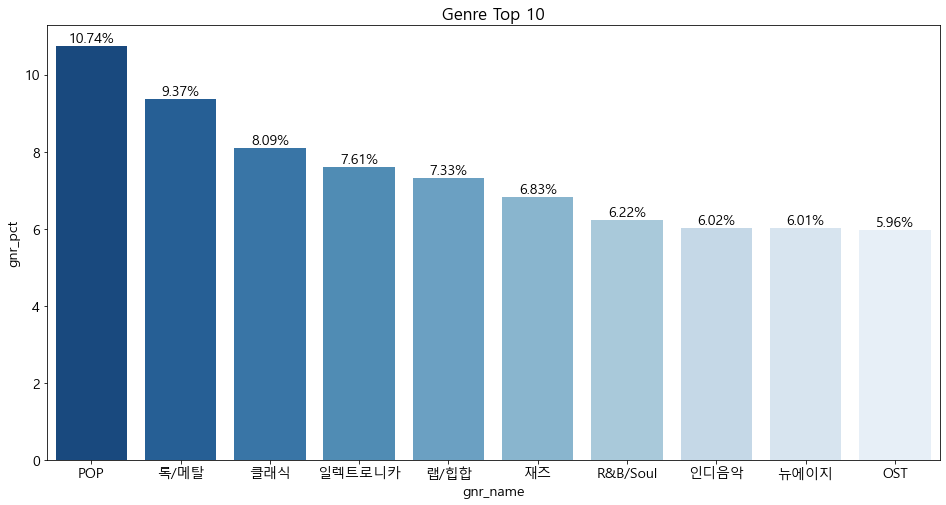

In [31]:
genre_top10 = pd.DataFrame(song_genre['gnr_name'].value_counts()).reset_index().rename(columns = {'index' : 'gnr_name',
                                                                                                    'gnr_name' : 'gnr_cnt'})
genre_top10['gnr_pct'] = round((genre_top10['gnr_cnt']/genre_top10['gnr_cnt'].sum())*100,2)
genre_top10.reset_index(drop = True, inplace = True)

fig , ax1 = plt.subplots(figsize=(16,8))
sns.barplot(genre_top10[:10]['gnr_name'],genre_top10[:10]['gnr_pct'],
            ax = ax1,
           palette= 'Blues_r')

for idx, value in enumerate(genre_top10[:10]['gnr_pct']):
    txt = f'{value}%'
    
    ax1.text(idx,value+0.1,txt, color='black',
             horizontalalignment = 'center')
ax1.set_title('Genre Top 10')

### 2.3.3.  장르별 가수 집계

In [32]:
POP = song_genre.query('gnr_name == "POP"')
POP = pd.DataFrame(POP['artist_name_basket'].value_counts()).rename(columns = {'artist_name_basket':'artist_cnt'})

ROCK = song_genre.query('gnr_name == "록/메탈"')
ROCK = pd.DataFrame(ROCK['artist_name_basket'].value_counts()).rename(columns = {'artist_name_basket':'artist_cnt'})

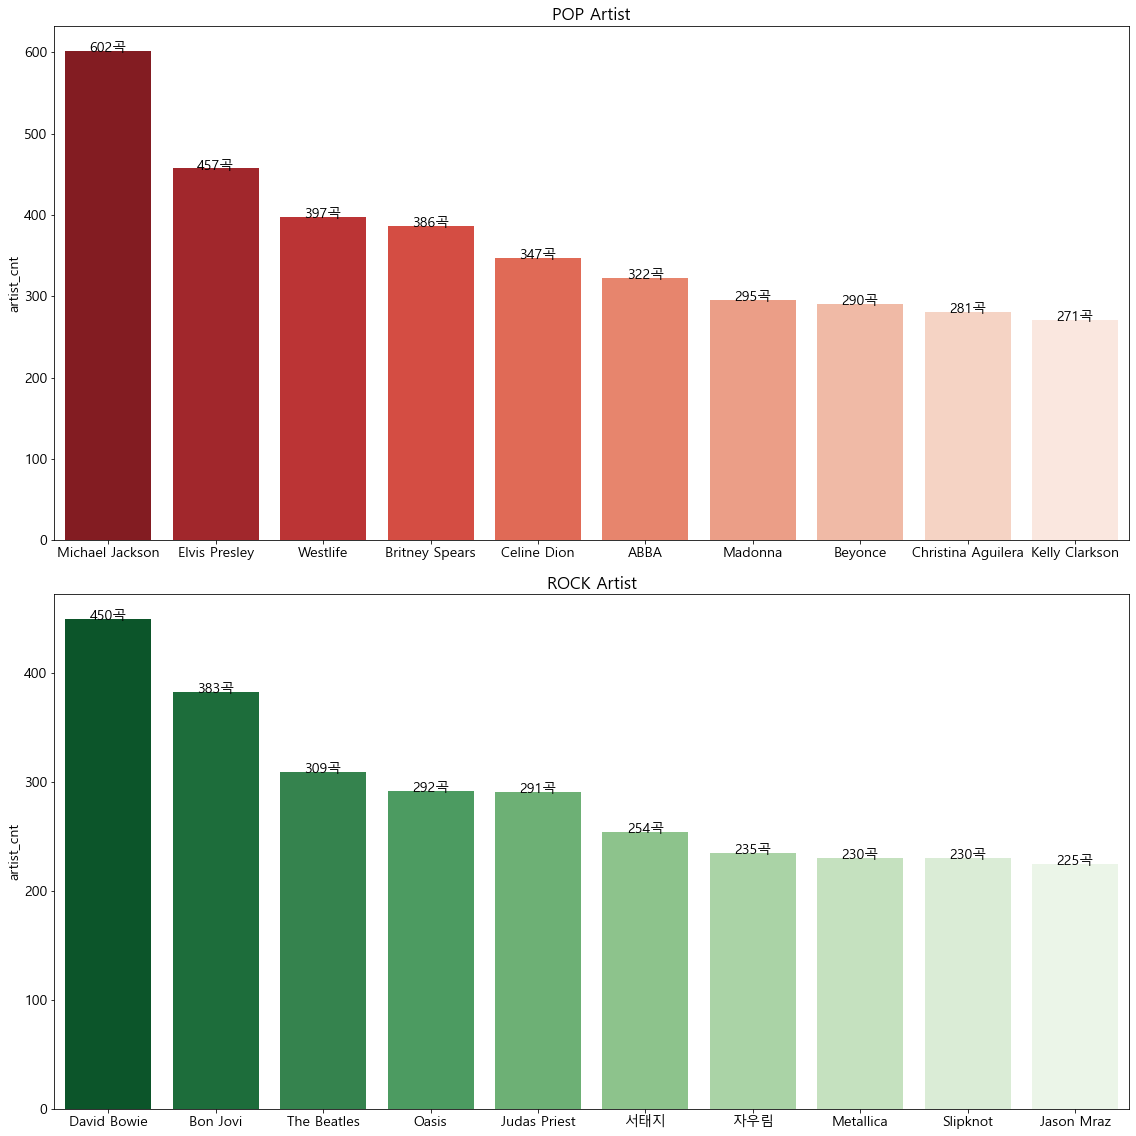

In [33]:
# POP Artist, ROCK Artist의 경우는 둘 다 1위가 Various Artists여서 그래프에서 제외
fig, (ax2,ax3) = plt.subplots(2,1, figsize=(16,16))

# POP
sns.barplot(POP[1:11].index,POP[1:11]['artist_cnt'],
            ax = ax2,
           palette= 'Reds_r')

for idx, value in enumerate(POP[1:11]['artist_cnt']):
    txt = f'{value}곡'
    
    ax2.text(idx,value+0.1,txt, color='black',
             horizontalalignment = 'center')
ax2.set_title('POP Artist')


#ROCK
sns.barplot(ROCK[1:11].index,ROCK[1:11]['artist_cnt'],
            ax = ax3,
           palette= 'Greens_r')

for idx, value in enumerate(ROCK[1:11]['artist_cnt']):
    txt = f'{value}곡'
    
    ax3.text(idx,value+0.1,txt, color='black',
             horizontalalignment = 'center')
ax3.set_title('ROCK Artist')
    

plt.tight_layout()
plt.show()

---

## 3.1 기본 정보

  - `tags` : 플레이리스트에 매핑된 태그
  - `id` : 플레이리스트 아이디
  - `plylst_title` : 플레이리스트 명
  - `songs` : 플레이리스트 내 수록된 곡 아이디
  - `like_cnt` : 플레이리스트 좋아요 횟수
  - `updt_date` : 플레이리스트 업데이트 일시

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115071 entries, 0 to 115070
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          115071 non-null  object
 1   id            115071 non-null  int64 
 2   plylst_title  115071 non-null  object
 3   songs         115071 non-null  object
 4   like_cnt      115071 non-null  int64 
 5   updt_date     115071 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


In [35]:
train.head()

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000


**결측치 확인**

In [36]:
train.isna().sum().sum()

0

In [37]:
len(train) == len(train['id'].unique())

True

## 3.2. 플레이리스트 Tags

### 3.2.1 태그 빈도수
가장 유저가 많이 작성한 태그에 대해서 확인해보았습니다. 장르 이외에 기분전환이나 감성 등 감정과 상황을 담은 태그가 높은 빈도를 보이는 것을 확인할 수 있었습니다. 

In [38]:
tag_total = []
train['tags'].map(lambda x : tag_total.extend(x))
tag_count = collections.Counter(tag_total)
tag_count_df = pd.DataFrame.from_dict(tag_count, orient='index').sort_values(by=0,ascending=False)
tag_count_df.columns = ['Count']

In [39]:
tag_list = set(np.concatenate(train['tags'].values))
print("중복을 제외한 태그의 총 개수 : ",len(tag_list))

display(tag_count_df)

중복을 제외한 태그의 총 개수 :  29160


,Count
기분전환,16465
감성,11417
휴식,11215
발라드,10796
잔잔한,10218
...,...
섹시한분위기,1
퓨젼재즈,1
ThankYouLord,1
드렁크타이거,1


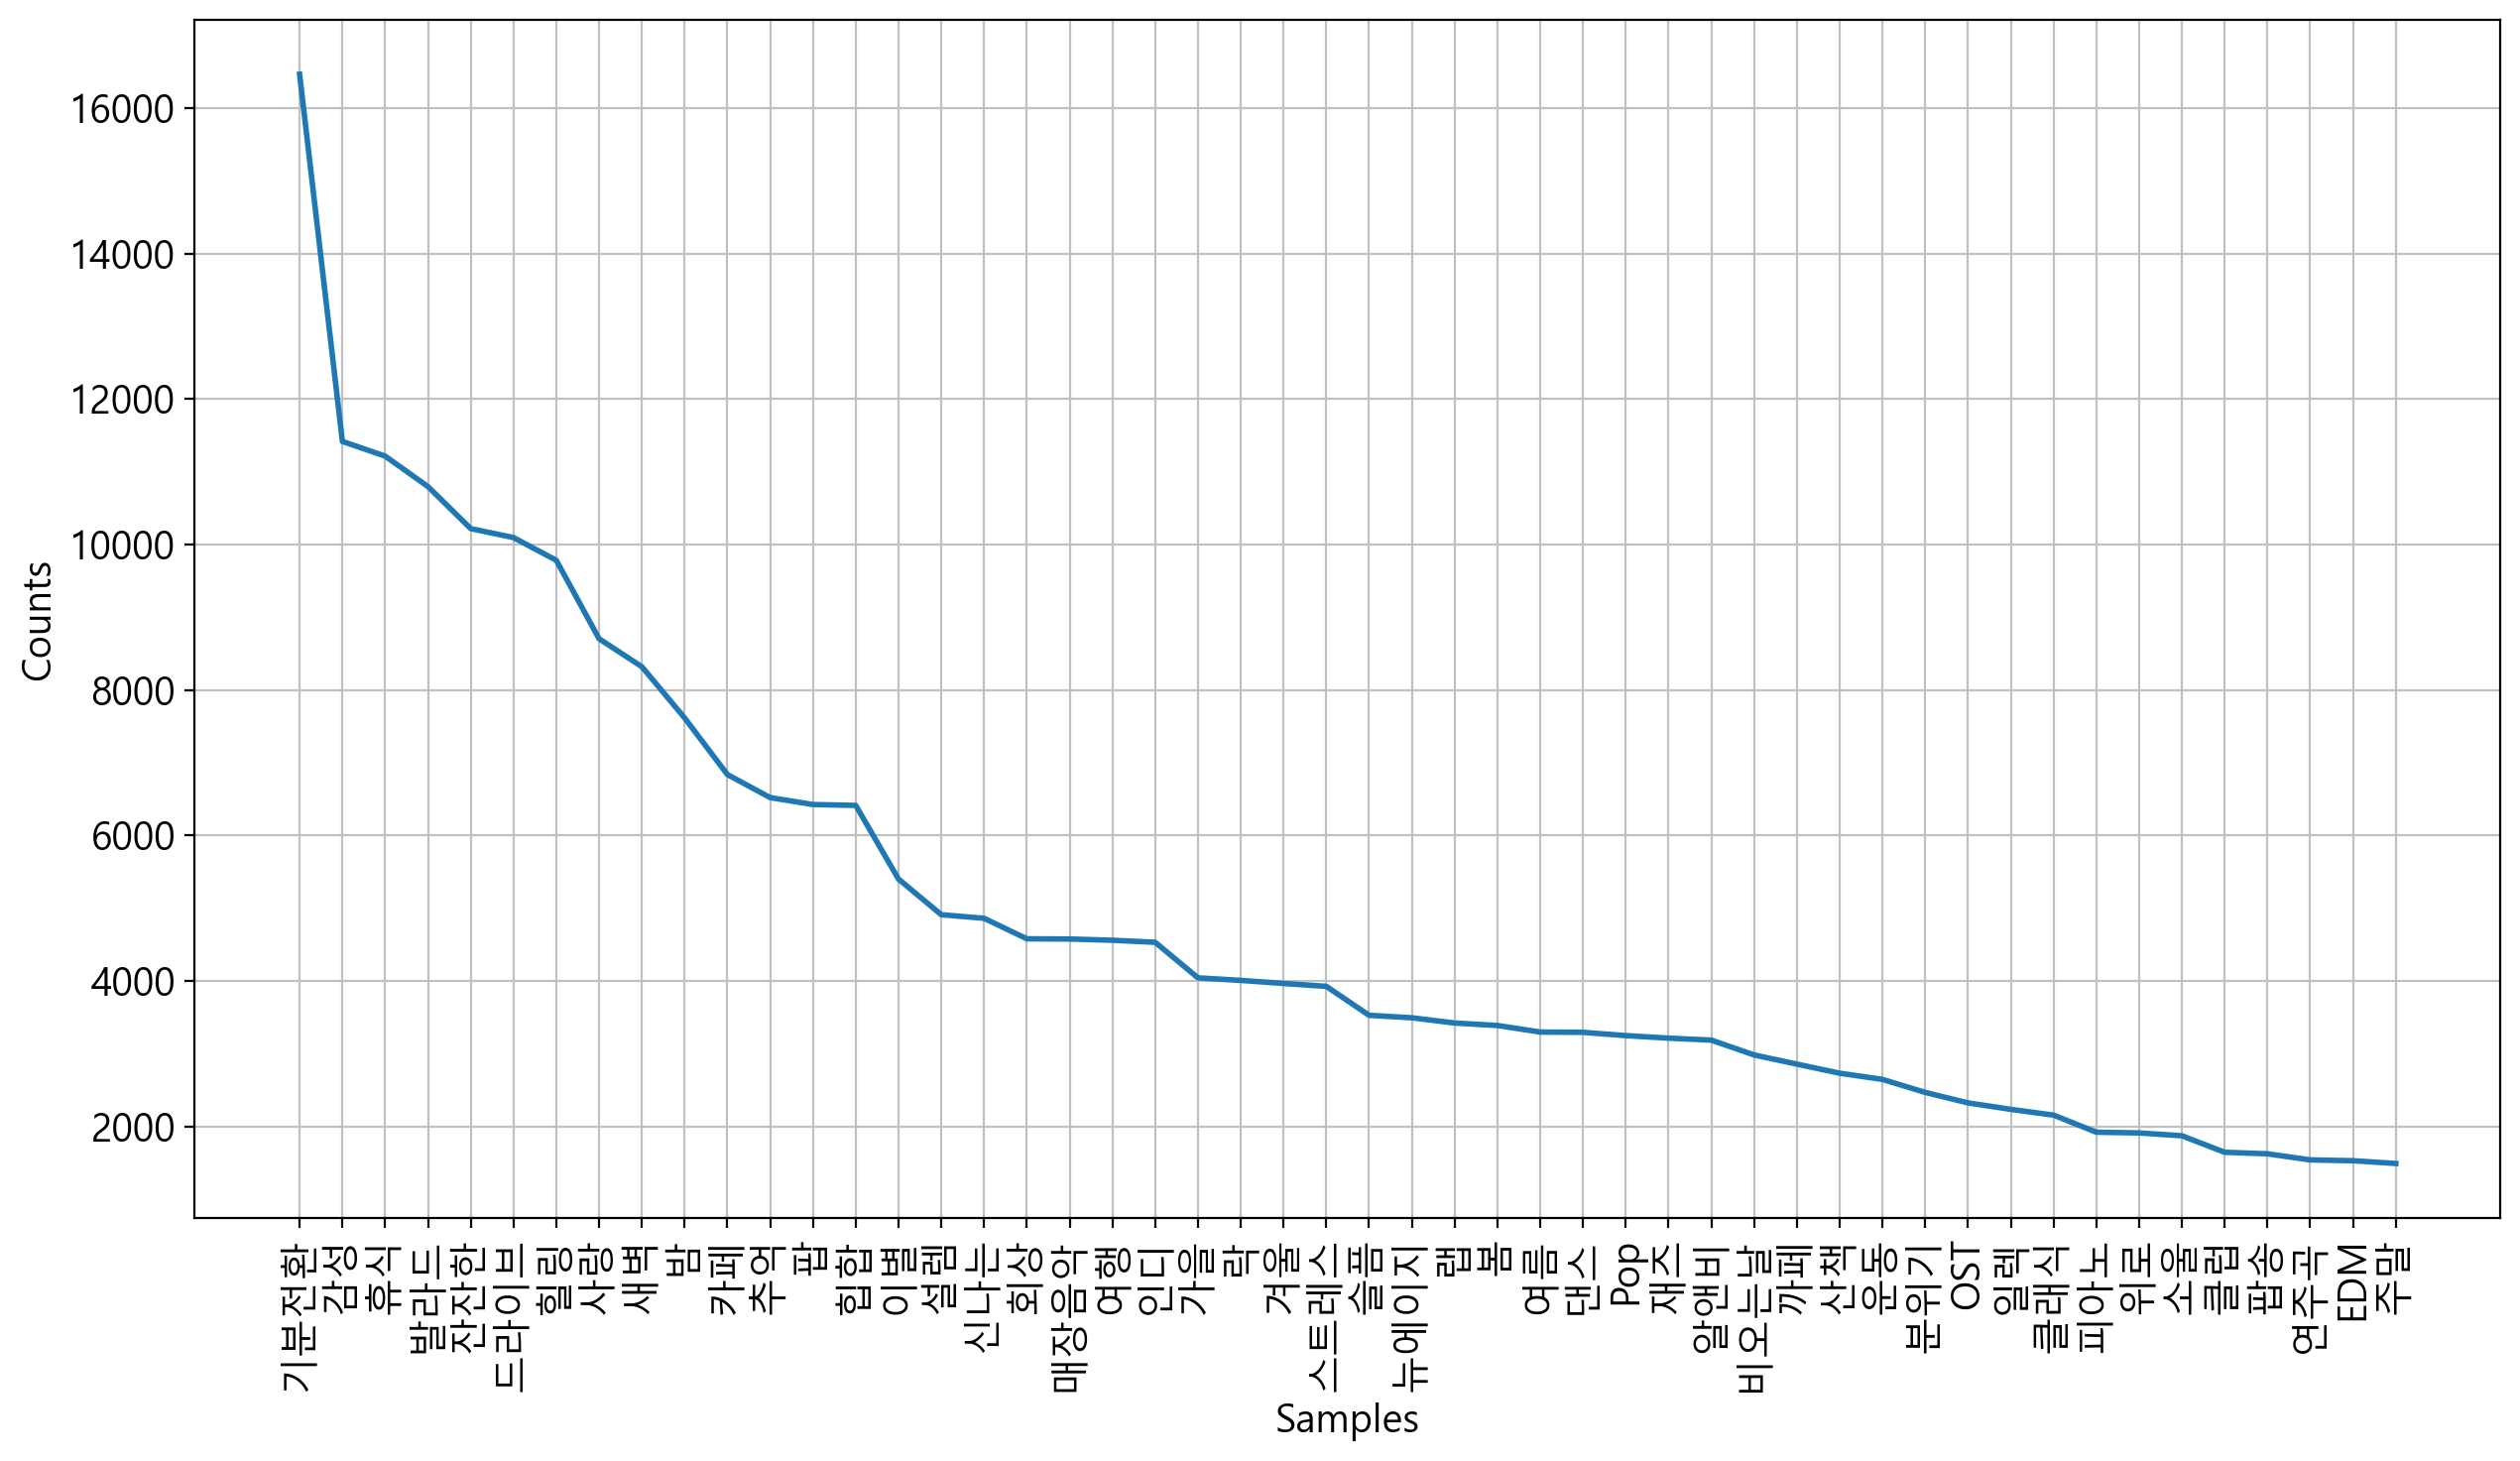

In [54]:
word_split = []

for i in train['tags']:
    for j in i:
        word_split.append(j)
        

plt.figure(figsize=(15,8), dpi = 200)
FreqDist(word_split).plot(50)
plt.show()

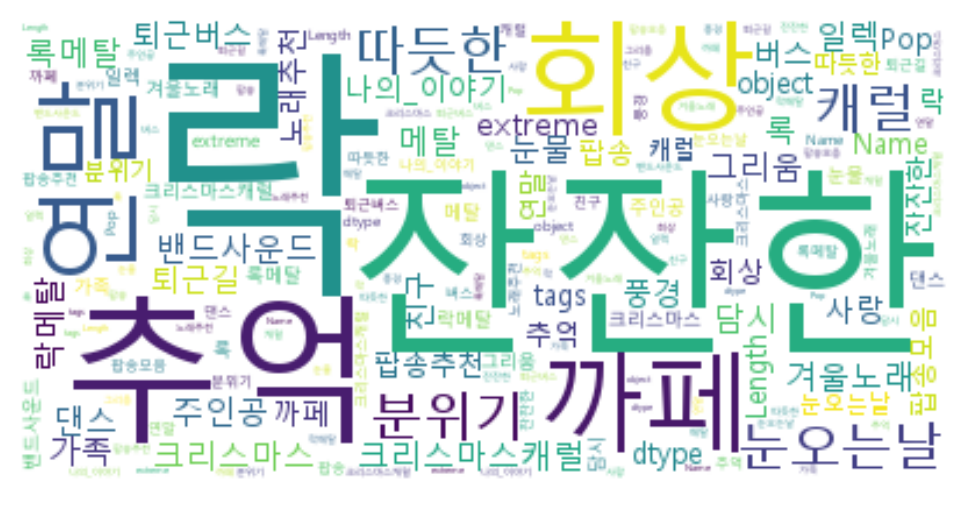

In [41]:
fig, ax = plt.subplots(dpi = 200)
wc = WordCloud(font_path=r'C:\Windows\Fonts\malgun.ttf',
               max_words=2000,
               background_color='white',
              repeat=True).generate(str(train['tags']))

ax.imshow(wc,interpolation='bilinear')
ax.axis('off')
plt.show()

### 3.2.2 좋아요 랭킹 상위 500개 플레이리스트의 태그 빈도수

그렇다면 실제 좋아요를 많이 받은 플레이리스트는 어떤 태그를 자주 달았는지 확인해보았습니다. 좋아요 기준으로 구분하지 않았을 때와 마찬가지로 기분전환이 가장 높았고, 많은 단어가 겹치는 것을 확인할 수 있었습니다.

기분전환    125
드라이브    114
팝        80
감성       69
카페       60
휴식       58
밤        52
힐링       50
매장음악     49
새벽       48
dtype: int64

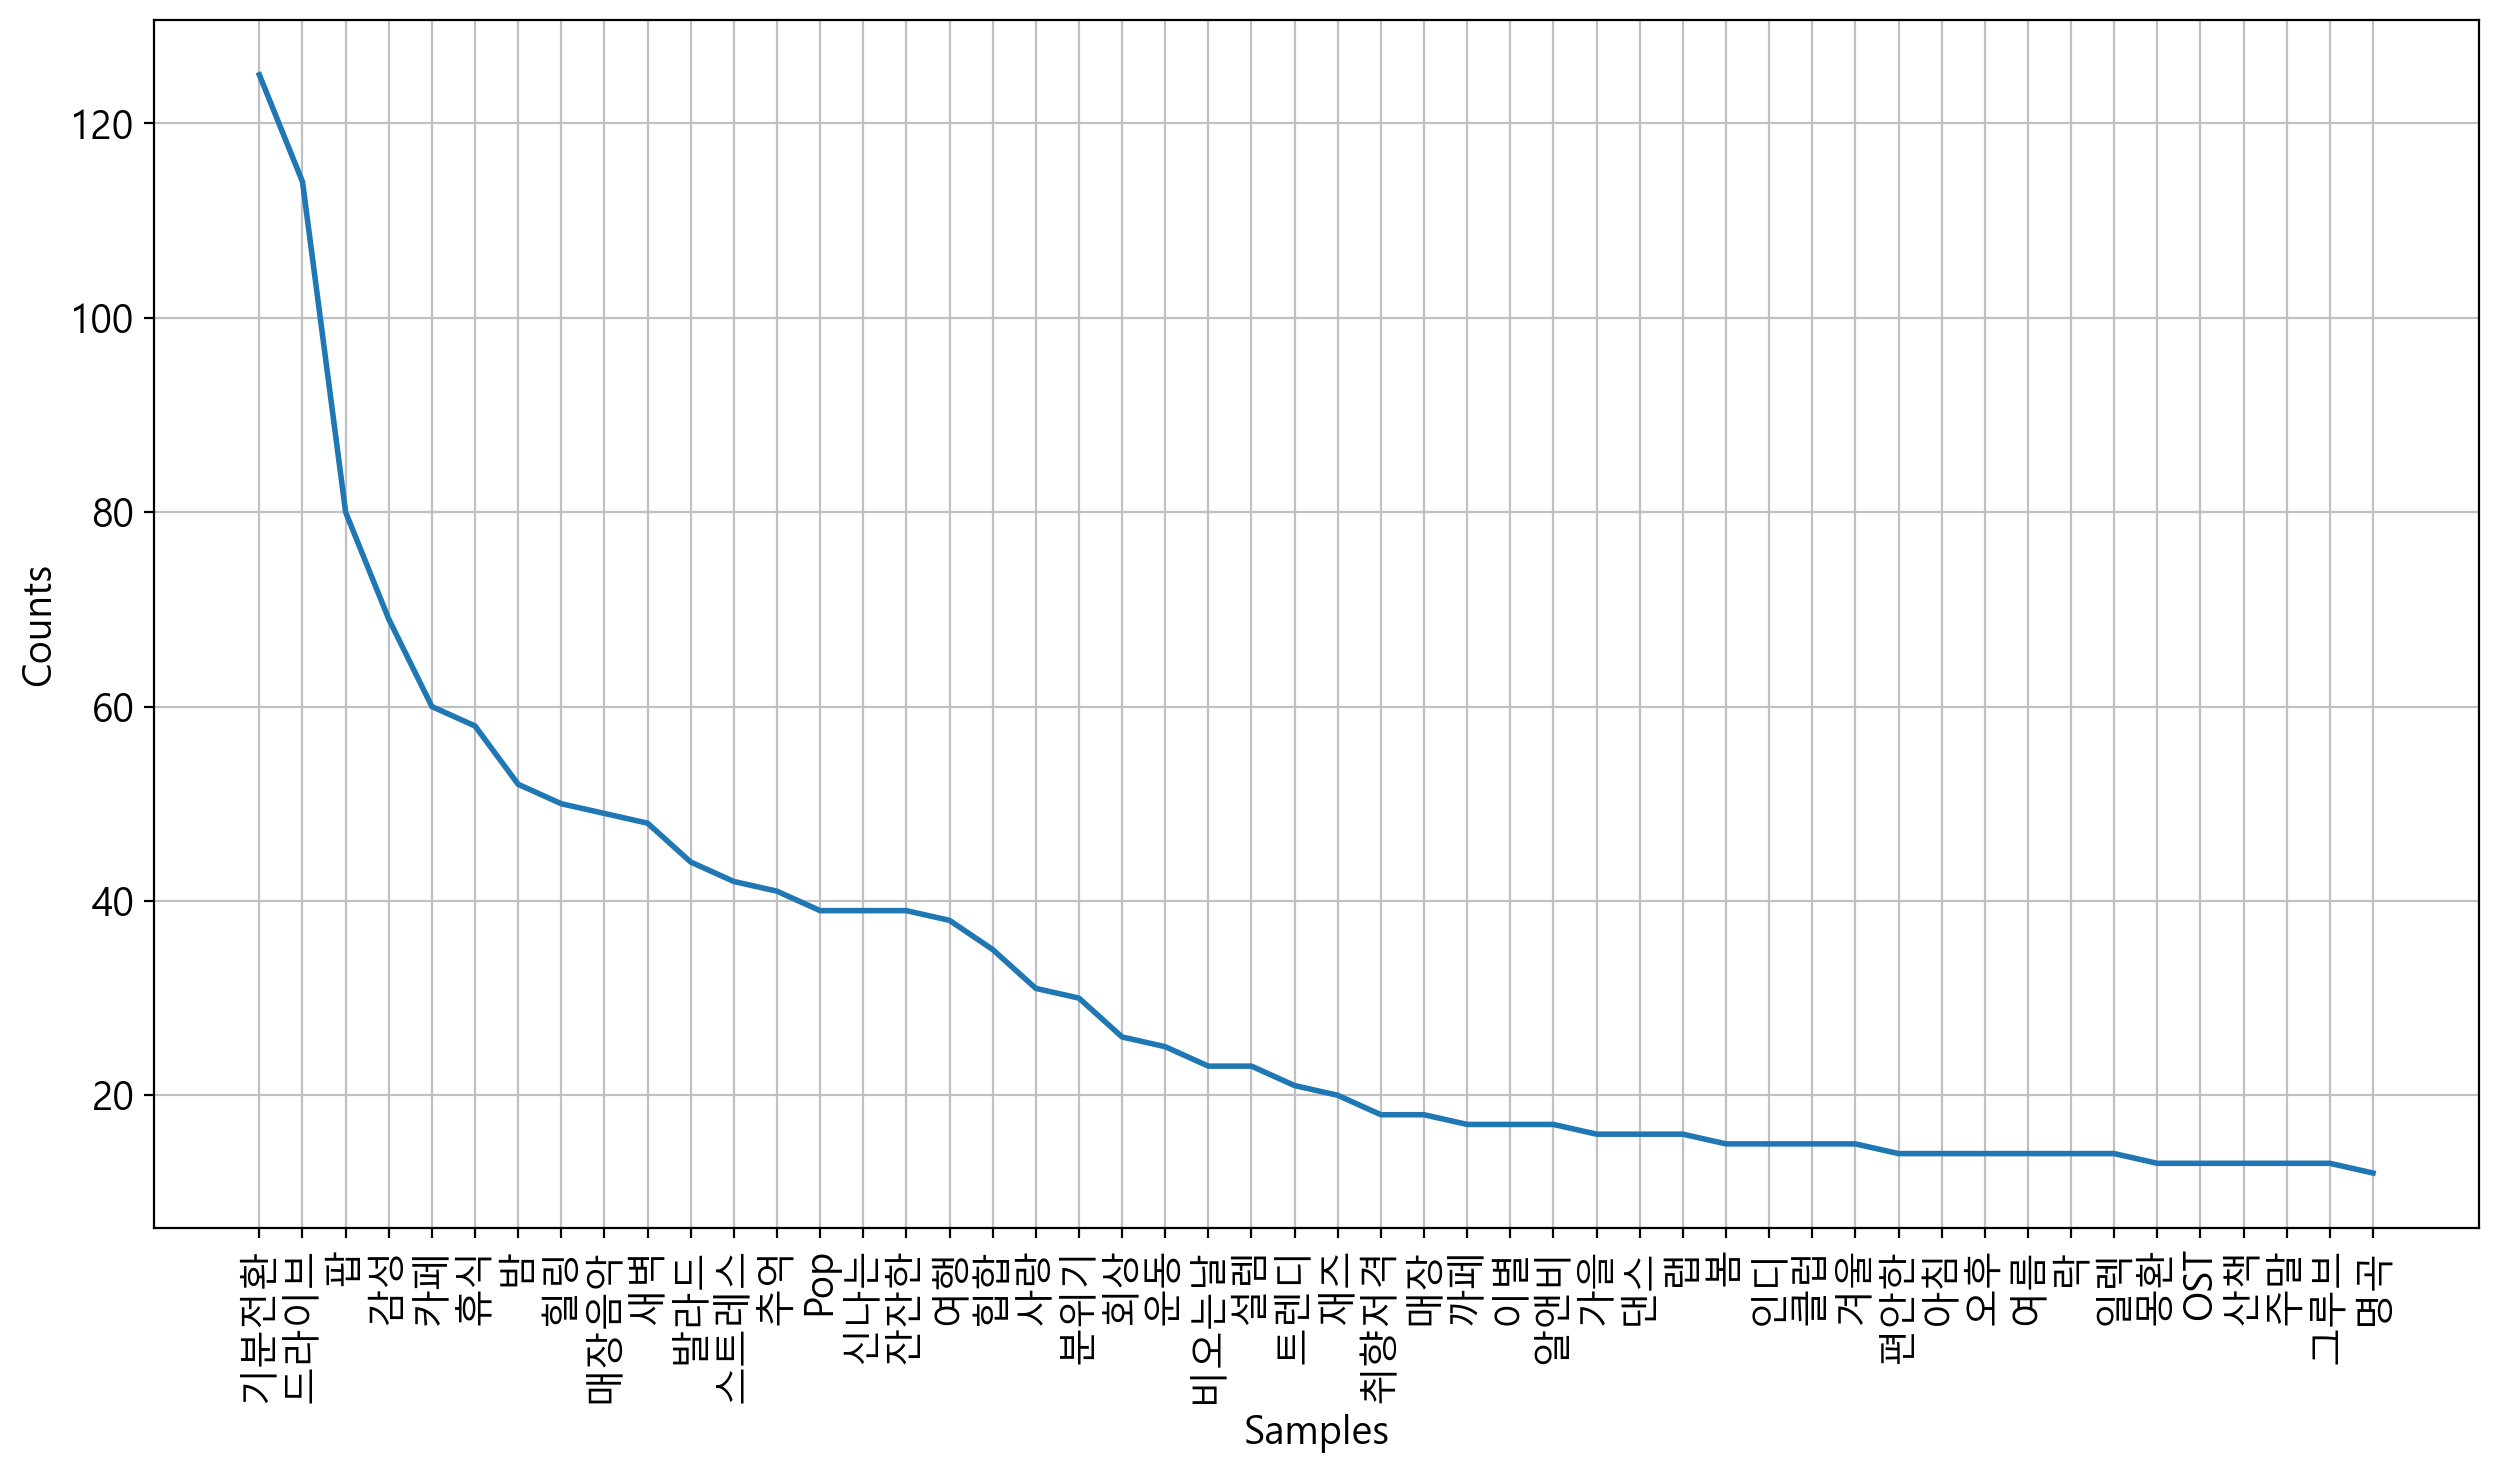

In [42]:
top500df = train.sort_values('like_cnt', ascending = False).head(500)

#  상위 500 플레이리스트의 3000개 등장 태그 목록
top500_tag_list = np.concatenate( top500df['tags'].values )

display(pd.Series(top500_tag_list).value_counts().head(10))

plt.figure(figsize=(15,8), dpi = 200)
FreqDist(top500_tag_list).plot(50)
plt.show()

### 3.2.3 비슷한 의미를 가지는 태그

In [43]:
temp=[]
for tag in tag_list:
    if tag.startswith('pop'):
        temp.append(tag)
temp

['popmusic',
 'pop추천',
 'pop인기',
 'popchart',
 'popsong',
 'poptop100',
 'pops',
 'pop학사전',
 'pop모집',
 'pop등']

In [44]:
temp=[]
for tag in tag_list:
    if tag.startswith('rock'):
        temp.append(tag)
temp

['rockandroll',
 'rock이그리울때',
 'rock_n_roll',
 'rock추천',
 'rocktheworld',
 'rockisnotdead',
 'rockband']

In [45]:
temp=[]
for tag in tag_list:
    if tag.startswith('락'):
        temp.append(tag)
temp

['락발',
 '락페의',
 '락가스펠',
 '락이즈얼라이브',
 '락보컬리스트',
 '락',
 '락_입문서',
 '락Top100',
 '락스타게임즈',
 '락한남자',
 '락음악추천',
 '락차트',
 '락킹',
 '락메탈',
 '락힙합',
 '락뮤직',
 '락스피릿을_깨우는_ROCK',
 '락스피릿',
 '락덕',
 '락사운드',
 '락페스티벌',
 '락밴드',
 '락발라드전설',
 '락발라드',
 '락인기',
 '락볼링장',
 '락커본능',
 '락페스트벌',
 '락커',
 '락큰롤',
 '락카페',
 '락은우리의주위에',
 '락모음',
 '락덕후',
 '락의선성시대',
 '락추천',
 '락페',
 '락락락',
 '락앤롤',
 '락의_매력에_빠져보고_싶을때',
 '락스타',
 '락음악']

## 플레이리스트 내 태그가 등장한 빈도 확인
한 태그가 플레이리스트에 몇 번 등장했는지 확인해보았습니다. 1, 2번 등장한 태그가 50%를 넘어가는 것을 확인할 수 있었습니다. 평균은 약 16%로 높았지만 최댓값 등 이상치의 영향으로 높게 분포 되어 있는 것을 확인했습니다.

In [46]:
def map_func(data, col1, col2): 
    # 플리 아이디 : col1, 수록곡 : col2
    plylst_song_map = data[[col1, col2]]

    # unnest col2
    plylst_song_map_unnest = np.dstack(
        (np.repeat(plylst_song_map[col1].values, list(map(len, plylst_song_map[col2]))), 
            np.concatenate(plylst_song_map[col2].values)))

    # unnested 데이터프레임 생성 : plylst_song_map
    plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
    plylst_song_map[col1] = plylst_song_map[col1].astype(str)
    plylst_song_map[col2] = plylst_song_map[col2].astype(str)

    # unnest 객체 제거
    del plylst_song_map_unnest
    return plylst_song_map

In [47]:
ply_song_map = map_func(train, 'id', 'songs')
temp = pd.DataFrame(ply_song_map['songs'].value_counts()).reset_index()
temp.columns = ['곡', '플레이리스트내의 등장횟수']
meta['id'] = meta['id'].astype(str)
temp = temp.merge(meta[['id', 'artist_name_basket', 'song_name', 'song_gn_gnr_basket']], how='left', left_on='곡', right_on='id')

temp.loc[0:4][['artist_name_basket', 'song_name']]

,artist_name_basket,song_name
0,[아이유],밤편지
1,[정준일],안아줘
2,[폴킴],비
3,[가을방학],가끔 미치도록 네가 안고 싶어질 때가 있어
4,[박효신],눈의 꽃


In [48]:
playlst_tag_map = map_func(train, 'id', 'tags')
temp = pd.DataFrame(playlst_tag_map['tags'].value_counts()).reset_index()
temp.columns = ['태그', '플레이리스트내의 등장횟수']

print("플레이리스트내 1번 등장한 태그의 수:", temp[temp['플레이리스트내의 등장횟수'] == 1].shape[0])
print("플레이리스트내 2번 이상 등장한 태그의 수:", temp[temp['플레이리스트내의 등장횟수'] > 1].shape[0])

플레이리스트내 1번 등장한 태그의 수: 17431
플레이리스트내 2번 이상 등장한 태그의 수: 11729


In [49]:
round(pd.DataFrame(temp['플레이리스트내의 등장횟수'].describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']]).T, 2)

,min,25%,50%,mean,75%,max,std
플레이리스트내의 등장횟수,1.0,1.0,1.0,16.34,3.0,16465.0,247.01


## 앨범별 수록곡의 등장 횟수 확인

앨범 별 수록곡은 평균적으로 몇개인지 확인했습니다. 중위수 1개, 평균값 2.46%로 굉장히 낮은 수치를 보였습니다. 이는 미니앨범 또는 단일곡 수록 앨범 등의 영향을 많이 받은 것으로 보입니다.

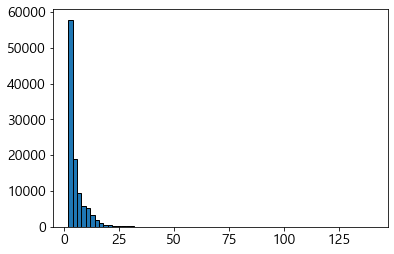

In [50]:
# 앨범별 수록된 곡의 수 테이블 
album_song_cnt = pd.DataFrame(meta.groupby('album_id').id.nunique())
# grid setting
grid_list = [i*2 for i in range(1, 71)]
# plotting
plt.hist(album_song_cnt['id'], grid_list, edgecolor = "black")
plt.show()

In [51]:
round(album_song_cnt.describe().loc[['min', '25%', '50%', 'mean', '75%', 'max', 'std']].transpose(), 2)

,min,25%,50%,mean,75%,max,std
id,1.0,1.0,1.0,2.46,2.0,142.0,3.55


### 3.3.1 노래별 등장 빈도수 분석

다음은 노래 별 플레이리스트 등장 빈도수를 분석해 어떤 노래가 가장 많은 플레이리스트에 담겼는지 확인했습니다.
발라드, 래퍼 노래가 상위권에 분포되어있는 모습입니다. 

In [52]:
#노래 count
songs_count = []
train['songs'].map(lambda x : songs_count.extend(x))
songs_count = collections.Counter(songs_count)
songs_count_df = pd.DataFrame.from_dict(songs_count,orient='index')
songs_count_df = songs_count_df.sort_values(by=0,ascending=False)
songs_count_df.columns = ['Count']

songs_count_df = songs_count_df.reset_index().rename(columns ={'index':'song_id'})
#meta에서 id와 제목, 가수를 가져옴
song_id_title =  meta[['id','song_name','artist_name_basket']].rename(columns ={'id':'song_id'})
# id로 merge
songs_count_df = songs_count_df.merge(song_id_title, on ='song_id')

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

**상위 20개의 노래**

In [ ]:
songs_count_df[['song_name','artist_name_basket','Count']].head(20)

### 3.3.2 플레이리스트 별 포함된 곡 수

플레이리스트는 10~30곡이 든 플레이리스트가 일반적으로 많았습니다. 

In [ ]:
train['playlist_length'] = train['songs'].map(lambda x : len(x))

print('플레이리스트 최대 곡 수 : ', max(train['playlist_length']))
print('플레이리스트 최소 곡 수 : ', min(train['playlist_length']))

plt.figure(figsize = (10,5))
train['playlist_length'].plot.hist(bins = 100,edgecolor = "black")
plt.show()

In [ ]:
#5개 미만은 플레이리스트의 기능을 하지 못한다고 가정

#곡 수가 5 미만인 플레이리스트 개수
len(train[train['playlist_length'] < 5])

## 3.4 플레이리스트 좋아요 수
- tag가 tag된 횟수 / tag의 길이와 좋아요 수와의 상관관계
- song이 포함된 횟수 / songs의 길이와 좋아요의 상관관계

플레이리스트의 좋아요 수와 곡수, 태그의 수는 큰 상관관계를 보이지는 않았습니다

In [ ]:
#정규화
qt = QuantileTransformer(n_quantiles=100000,output_distribution='normal')
train['normal_cnt'] = qt.fit_transform(train['like_cnt'].values.reshape(-1,1))

### 3.4.1 플레이리스트 곡 수와 좋아요 수의 상관관계

In [ ]:
# 그냥 count
train[['like_cnt','playlist_length']].corr()

In [ ]:
# 정규화된 count
train[['normal_cnt','playlist_length']].corr()

In [ ]:
sns.scatterplot(y='like_cnt',x='playlist_length',data = train[['like_cnt','playlist_length']])
plt.show()

- 상당히 낮은 상관관계를 보인다. 

### 3.4.2 플레이리스트 태그 수와 좋아요 수의 상관관계

In [ ]:
def tag_sum(x):
    temp = 0
    for value in x:
        temp = temp + tag_count[value]
    return temp / len(x)        

train['tag_mean'] =  train['tags'].map(tag_sum)

In [ ]:
# 그냥 count
train[['tag_mean','like_cnt']].corr()

In [ ]:
# 정규화된 count
train[['tag_mean','normal_cnt']].corr()

In [ ]:
sns.scatterplot(y='like_cnt',x='tag_mean',data = train[['tag_mean','like_cnt']])
plt.show()
# 좋아요를 뭔가 계층적으로 나눠서 하면 의미가 생길지도? 4분위수 8분위수 혹은 10단위 

- 역시 낮은 상관관계를 보인다. 

### 3.4.3 플레이리스트 곡이 포함된 횟수 좋아요 수의 상관관계

In [ ]:
def songs_sum(x):
    temp = 0
    for value in x:
        temp = temp + songs_count[value]
    return temp / len(x)        

train['songs_mean'] = train['songs'].map(songs_sum)

# 좋아요를 뭔가 계층적으로 나눠서 하면 의미가 생길지도? 4분위수 8분위수 혹은 10단위 

In [ ]:
# 그냥 count
train[['songs_mean','like_cnt']].corr()

In [ ]:
# 정규화된 count
train[['songs_mean','normal_cnt']].corr()

In [ ]:
sns.scatterplot(y='like_cnt',x='songs_mean',data = train[['songs_mean','like_cnt']])
plt.show()

- 역시 낮은 상관관계를 보인다. 

### 3.4.2 등록날짜와 좋아요 수의 상관관계

등록날짜 또한 낮은 상관관계를 보였습니다

In [ ]:
# datatime으로 만들기
train['updt_date'] = pd.to_datetime(train['updt_date'])

In [ ]:
def to_date_2004(x):
    year = (x.year - 2004)*365
    month = (x.month)*30
    date = x.day
    
    return year+month+date


train['updt_date_to_date'] = train['updt_date'].map(to_date_2004)

# 좋아요를 뭔가 계층적으로 나눠서 하면 의미가 생길지도? 4분위수 8분위수 혹은 10단위 

In [ ]:
train[['updt_date_to_date','like_cnt']].corr()

In [ ]:
train[['updt_date_to_date','normal_cnt']].corr()

- 매우 낮다

> 정규화된 데이터로 상관관계 다시 탐색해보기

In [ ]:
train.head(1)